<a href="https://colab.research.google.com/github/Maneekul/Image1/blob/main/Detect_Fish.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix
import skimage.morphology as skmorph
from  skimage.measure import regionprops


In [18]:
def mahalanobis(img1, center, cutoff):

    y,x,z = img1.shape

    positions = img1.reshape(y*x, z)
    centers = center*np.ones((y*x, 1))

    cov = np.cov(positions.T)
    inv_cov = np.linalg.inv(cov)

    delta = positions - centers
    distances = np.sqrt(np.einsum("ij, jk, ik->i", delta, inv_cov, delta))
    distances = distances.reshape((y,x))

    B = np.ones(gray.shape)
    B[distances>cutoff] = 0
    B[distances<=cutoff] = 1
    return B

def MyEuclidean(img1,center,D_cutoff):
    y,x,c = img1.shape
    img_rec = img1.reshape(y*x,c)

    Mycenter = center*np.ones((y*x,1))
    MyDistance = np.sqrt(np.sum((img_rec - Mycenter)**2, axis = 1))
    MyDistance = MyDistance.reshape((y,x))

    A= np.ones(gray.shape)
    A[MyDistance>D_cutoff] = 0
    A[MyDistance<=D_cutoff] = 1
    return A

def kmeanSegmentation(img,k):
    y, x, z  = img.shape

    input_rec = img.reshape(y*x,z)
    input_rec = input_rec.astype(np.float32)

    criteria = (cv2.TERM_CRITERIA_MAX_ITER+ cv2.TERM_CRITERIA_EPS, 100, 0.2)
    _, label_rec, center = cv2.kmeans(input_rec,k,None,criteria,10,cv2.KMEANS_RANDOM_CENTERS)

    label_rec = label_rec.flatten()
    label_img = label_rec.reshape((y,x))

    return label_img, center.astype(np.uint8)

def selectGroup2(label_img, centers):
    select_group = np.argwhere(centers[:,0]>np.mean(centers[:,0])).flatten

    output_img = np.isin(label_img,select_group)
    output_img = output_img.astype(np.uint8)
    return  output_img

def selectGroup(label_img, centers):
    output_img = np.zeros_like(label_img)

    red_mean = np.mean(centers[:,0])

    for y in range(label_img.shape[0]):
        for x in range(label_img.shape[1]):
            red_center = centers[label_img[y,x]][0]
            if red_center > red_mean:
                output_img[y,x] = 1
            else:
                output_img[y,x] = 0
    return output_img

def CCselectloop(label_img):
    min_size = int((label_img.shape[0]*label_img.shape[1])*0.000004) #0.00001

    labels , counts = np.unique(label_img,return_counts=True)

    output_img = label_img.copy()

    for y in range(label_img.shape[0]):
        for x in range(label_img.shape[1]):
            if counts[label_img[y,x]] >= min_size and label_img[y,x] != 0:
                output_img[y,x] = 1
            else:
                output_img[y,x] = 0
    return output_img


In [17]:
def find_IoU(gt_img,output_img):
    intersect = np.logical_and(gt_img,output_img)
    union = np.logical_or(gt_img,output_img)
    IoU = np.sum(intersect) / np.sum(union)
    return IoU

def segmentConfusionMatrix(gt_img, output_img):
    matrix = confusion_matrix(gt_img.flatten(),output_img.flatten()).T
    con_matrix = np.zeros((matrix.shape[0]+1,matrix.shape[1]+1))
    con_matrix[:2,:2] = matrix

    prec_bg = matrix[0,0] / np.sum(matrix[0,:])
    prec_fg = matrix[1,1] / np.sum(matrix[1,:])
    con_matrix[:2,-1] = [prec_bg, prec_fg]

    rec_bg = matrix[0,0] / np.sum(matrix[:,0])
    rec_fg = matrix[1,1] / np.sum(matrix[:,1])
    con_matrix[-1,:2] = [rec_bg, rec_fg]

    accuracy =   (matrix[0,0] + matrix[1,1]) / np.sum(matrix)
    con_matrix[-1,-1] = accuracy

    return con_matrix

In [19]:
def objectFeatures(seg_img):
    _,label_img1 = cv2.connectedComponents(seg_img)
    feature_vect = regionprops(label_img1)

    X = []
    obj_pos = []

    for i in range(len(feature_vect)):
        area = feature_vect[i].area
        eccen = feature_vect[i].eccentricity

        bbox = feature_vect[i].bbox

        X.append([area,eccen])
        obj_pos.append(bbox)

    return X, obj_pos

def classifierFeatures(X,seg_img ):
    total_area = seg_img.shape[0]*seg_img .shape[1]
    #print(total_area)

    y = []

    for i in range(len(X)):
        if (X[i][0] <= 259 and X[i][0] >= 50 and X[i][1] >= 0.8): # X[i][0] <= 200 and X[i][0] >= 80
            output_class = "A"
        elif (X[i][0] <= 80000 and X[i][0] >= 260 and X[i][1] >= 0 ):
            output_class = "B"

        elif (X[i][0] > 80000  and X[i][1] >= 0):
            output_class = "C"
        else:
            output_class = "N"
        y.append(output_class)
    return y

def displayDetection(input_img,y,obj_pos):
    output_img1 = input_img.copy()

    for i in range(len(y)):
        if y[i] == "A":
            pos = obj_pos[i]
            output_img1 = cv2.rectangle(output_img1, (pos[1],pos[0]),(pos[3],pos[2]),(0,0,255),3)

        elif y[i] == "B":
            pos = obj_pos[i]
            output_img1 = cv2.rectangle(output_img1, (pos[1],pos[0]),(pos[3],pos[2]),(0,255,0),3)

        elif y[i] == "C":
            pos = obj_pos[i]
            output_img1 = cv2.rectangle(output_img1, (pos[1],pos[0]),(pos[3],pos[2]),(255,0,0),3)
    return output_img1

In [20]:
def objectFeatures_gt(seg_img):
    _,label_img1 = cv2.connectedComponents(seg_img)
    feature_vect = regionprops(label_img1)

    X = []
    obj_pos = []

    for i in range(len(feature_vect)):
        area = feature_vect[i].area
        eccen = feature_vect[i].eccentricity

        bbox = feature_vect[i].bbox

        X.append([area,eccen])
        obj_pos.append(bbox)

    return X, obj_pos

def classifierFeatures_gt(X,seg_img):
    total_area = seg_img.shape[0]*seg_img .shape[1]
    #print(total_area)

    y = []

    for i in range(len(X)):
        if (X[i][0] <= 259 and X[i][0] >= 50 and X[i][1] >= 0.8): # X[i][0] <= 200 and X[i][0] >= 80
            output_class = "A"

        else:
            output_class = "N"
        y.append(output_class)
    return y

def displayDetection_gt(input_img,y,obj_pos):
    output_img1 = input_img.copy()

    for i in range(len(y)):
        if y[i] == "A":
            pos = obj_pos[i]
            output_img1 = cv2.rectangle(output_img1, (pos[1],pos[0]),(pos[3],pos[2]),(0,0,255),3)

    return output_img1


My_IOU =  0.29055051408460947
My_Confusion = 
[[1.57426080e+07 3.11329000e+05 9.80607311e-01]
 [4.69213000e+05 3.19666000e+05 4.05215502e-01]
 [9.71057354e-01 5.06606233e-01 9.53657274e-01]]


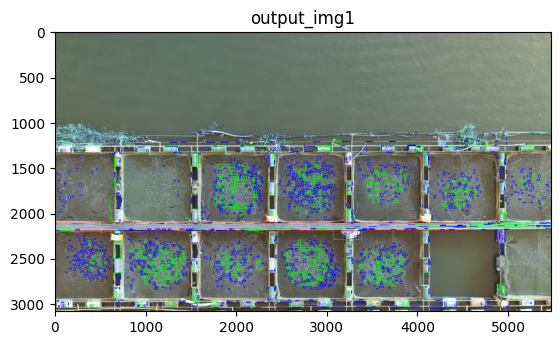

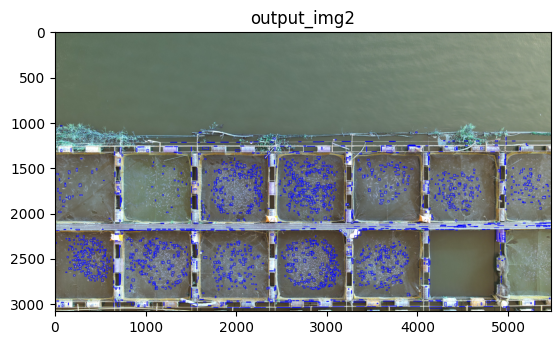

In [21]:
# Load the image
img = cv2.imread(r"/content/drive/MyDrive/Image_image/Fish_image/20 (2).JPG")
img1 = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
img2 = cv2.cvtColor(img,cv2.COLOR_RGB2HSV)
gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

# --> Read Groundtruth and convert to grayscale
gt_img = cv2.imread(r"/content/drive/MyDrive/Image_image/Fish_Grounnd/20 (2)_groundtruth.jpg")
gt_img = cv2.cvtColor(gt_img,cv2.COLOR_BGR2GRAY)
## --> Round gray into white (make it has only black and white ,not gray)
gt_img = np.where(gt_img > 100, 1, 0)

gt_img = gt_img.astype(np.uint8)

seg_img = mahalanobis(img1,(191,160,160),2)
#seg_img = MyEuclidean(img1,(220,160,168),65)

seg_img  = seg_img.astype(np.uint8)

#plt.imshow(seg_img,cmap="gray")
#plt.title("seg_img")
#plt.show()
#plt.imshow(seg_img2,cmap="gray")
#plt.title("seg_img2")
#plt.show()

_, label_img = cv2.connectedComponents(seg_img)
output_img = CCselectloop(label_img)
output_img = output_img.astype(np.uint8)


my_iuo = find_IoU(gt_img,output_img)
print("My_IOU = ",my_iuo)
my_confusion = segmentConfusionMatrix(gt_img, output_img)
print("My_Confusion = ")
print(my_confusion)

feture_vect = regionprops(label_img)
for i in range(len(feture_vect)):
    obj = feture_vect[i].image
    #plt.imshow(obj,cmap="gray")
    #plt.show()

#####################################################################################################################################
# classifier and detection
X, obj_pos = objectFeatures(output_img)
y = classifierFeatures(X,output_img)
output_img1 =  displayDetection(img,y,obj_pos)
#print(y)
plt.imshow(output_img1,cmap="gray")
plt.title("output_img1")
plt.show()
#####################################################################################################################################
# ===> classifier single fish from image
X2, obj_pos2 = objectFeatures_gt(seg_img)
y2 = classifierFeatures_gt(X2,seg_img)
output_img2 =  displayDetection_gt(img,y2,obj_pos2)
#####################################################################################################################################
plt.imshow(output_img2,cmap="gray")
plt.title("output_img2")
plt.show()
